In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as scst

plt.style.use('astroandes.mplstyle')

In [2]:
def error_median_bootstrap(x):
    n_iter = 100
    n = len(x)
    ii = np.arange(n)
    medians = np.zeros(n_iter)
    for i in range(n_iter):
        ids = np.random.choice(ii, size=n)
        medians[i] = np.median(x[ids])
    return np.std(medians)

In [39]:
n_box = 20
mean_tan_vel_all = np.ones(n_box)
mean_tan_vel_high = np.ones(n_box)

error_tan_vel_all = np.ones(n_box)
error_tan_vel_high = np.ones(n_box)


mean_rad_vel_all = np.ones(n_box)
mean_rad_vel_high = np.ones(n_box)

error_rad_vel_all = np.ones(n_box)
error_rad_vel_high = np.ones(n_box)

circular_beta_all = np.ones(n_box)
circular_beta_high = np.ones(n_box)


error_circular_beta_all = np.ones(n_box)
error_circular_beta_high = np.ones(n_box)

all_tan_vel = np.empty((0))
all_rad_vel =  np.empty((0))
all_pec_vel =  np.empty((0))

for box_id in range(n_box):
    filename = '../data/abacus/summary_velocities_abacus_planck_00_box_{:02d}.dat'.format(box_id)
    data = np.loadtxt(filename)
    pec_vel = data[:,0]
    tan_vel = data[:,1]
    rad_vel = data[:,2]
    
    all_pec_vel = np.append(all_pec_vel, pec_vel)
    all_tan_vel = np.append(all_tan_vel, tan_vel)
    all_rad_vel = np.append(all_rad_vel, rad_vel)
    
    
    ii = np.argsort(pec_vel)
    nn = len(pec_vel)
    ii4 = ii[-nn//4:]
    mean_tan_vel_all[box_id] = np.median(tan_vel)
    mean_tan_vel_high[box_id] = np.median(tan_vel[ii4])
    error_tan_vel_all[box_id] = error_median_bootstrap(tan_vel)
    error_tan_vel_high[box_id] = np.std(tan_vel[ii4])/np.sqrt(np.count_nonzero(tan_vel[ii4]))
    mean_rad_vel_all[box_id] = error_median_bootstrap(rad_vel)
    mean_rad_vel_high[box_id] = np.mean(rad_vel[ii4])
    error_rad_vel_all[box_id] = np.std(rad_vel)/np.sqrt(np.count_nonzero(rad_vel))
    error_rad_vel_high[box_id] = np.std(rad_vel[ii4])/np.sqrt(np.count_nonzero(rad_vel[ii4]))

all_beta = 1.0 - 0.5*(all_tan_vel**2/all_rad_vel**2)

In [40]:
n_bins = 26
pec_vel_bins = np.linspace(0,1000,n_bins)
pec_vel_center = 0.5*(pec_vel_bins[1:]+pec_vel_bins[:-1])
mean_tan_vel = np.ones(n_bins-1)
error_tan_vel = np.ones(n_bins-1)
mean_rad_vel = np.ones(n_bins-1)
error_rad_vel = np.ones(n_bins-1)
mean_beta = np.ones(n_bins-1)
error_beta = np.ones(n_bins-1)

for i in range(n_bins-1):
    min_pec_vel = pec_vel_bins[i]
    max_pec_vel = pec_vel_bins[i+1]
    ii = (all_pec_vel > min_pec_vel) & (all_pec_vel < max_pec_vel)
    mean_tan_vel[i] = np.median(all_tan_vel[ii])
    mean_rad_vel[i] = np.median(all_rad_vel[ii])
    mean_beta[i] = np.median(all_beta[ii])

    error_tan_vel[i] = error_median_bootstrap(all_tan_vel[ii])
    error_rad_vel[i] = error_median_bootstrap(all_rad_vel[ii])
    error_beta[i] = error_median_bootstrap(all_beta[ii])

[ 3.71676581e-05 -4.71737080e-03  9.58310622e+01]
[ 1.37866126e-05 -8.32622349e-03 -1.21713697e+02]
[-4.14460379e-07  1.55808395e-04  6.94420702e-01]


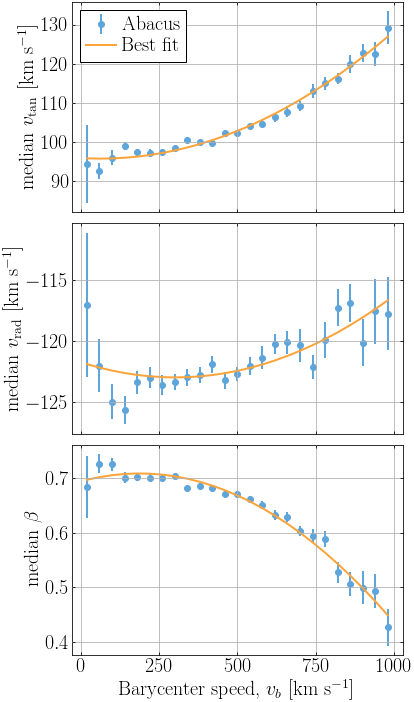

In [62]:
plt.figure(figsize=(6,10))

c = np.polyfit(pec_vel_center, mean_tan_vel, 2)
print(c)
fit_mean_tan_vel = pec_vel_center.copy()*0
for i in range(3):
    fit_mean_tan_vel += c[i] * pec_vel_center**(2-i)

ax1 = plt.subplot(3,1,1)
plt.errorbar(pec_vel_center, mean_tan_vel, error_tan_vel, fmt='o', label='Abacus')
plt.errorbar(pec_vel_center, fit_mean_tan_vel, label='Best fit')
_=plt.yticks(np.arange(5)*10+ 90)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel(r"median $v_{\mathrm{tan}}$ [km s$^{-1}$]")
plt.grid()
plt.legend()

c = np.polyfit(pec_vel_center, mean_rad_vel, 2)
print(c)
fit_mean_rad_vel = pec_vel_center.copy()*0
for i in range(3):
    fit_mean_rad_vel += c[i] * pec_vel_center**(2-i)


ax2 = plt.subplot(3,1,2, sharex=ax1)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)


plt.errorbar(pec_vel_center, mean_rad_vel, error_rad_vel, fmt='o')
plt.errorbar(pec_vel_center, fit_mean_rad_vel)
plt.ylabel(r"median $v_{\mathrm{rad}}$ [km s$^{-1}$]")
#plt.xlabel(r"Barycenter speed $v_{b}$ [km s$^{-1}$]")
plt.grid()



c = np.polyfit(pec_vel_center, mean_beta, 2)
print(c)
fit_beta = pec_vel_center.copy()*0
for i in range(3):
    fit_beta += c[i] * pec_vel_center**(2-i)

ax3 = plt.subplot(3,1,3, sharex=ax1)
# make these tick labels invisible
#plt.setp(ax2.get_xticklabels(), visible=False)


plt.errorbar(pec_vel_center, mean_beta, error_beta, fmt='o')
plt.errorbar(pec_vel_center, fit_beta)
plt.ylabel(r"median $\beta$")
plt.xlabel(r"Barycenter speed, $v_{b}$ [km s$^{-1}$]")
plt.grid()
plt.tight_layout()
plt.savefig("rad_tan.pdf")

In [64]:
len(all_beta)

176563